# Evaluate BleTIES MILRAA output with simulated PacBio reads

In [1]:
import json
import re
import glob
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio import Seq
from Bio import pairwise2

from collections import defaultdict

In [2]:
# Load previously annotated IES coordinates from published sequences
with open("ref/ptetraurelia_mac_51.min100k_max100N.iescoords.json", "r") as fh:
    iescoords = json.load(fh)

Evaluate the following:

 * Number of IESs recovered vs. MAC+IES average read coverage
  * Thereof: Number with correct coordinate; TA junction; correct length
 * Number of mismatches between assembled IES sequence and vs. MAC+IES average read coverage

In [3]:
# fields to report
# iescov, ID, scaffold, coord, TA, length, score (coord, coord_TA, coord_TA_len)
out = []
for iescov in ['00','05','10','20','40']:
    with open(f"bleties_pb/ptet_sim_clr.mix{iescov}.milraa_subreads.milraa_ies.gff3","r") as fh:
        for line in fh:
            if not re.match(r"#", line):
                spl=line.rstrip().split("\t")
                scaff=spl[0]
                coord=spl[3]
                outcoord = coord
                attr=spl[-1].rstrip(";").split(";")
                attrdict={a.split("=")[0]:a.split("=")[1] for a in attr}
                score = "nomatch"
                if "ta_pointer_start" in attrdict and attrdict["ta_pointer_start"] in iescoords[scaff]:
                    outcoord = attrdict["ta_pointer_start"]
                    # Correct coordinate and TA pointer present
                    if int(attrdict["IES_length"]) == iescoords[scaff][attrdict["ta_pointer_start"]]:
                        # Correct coordinate and TA pointer and length
                        score = "coord_TA_len"
                    else:
                        # Correct coordinate and TA pointer but wrong length
                        score = "coord_TA"
                else:
                    if coord in iescoords[scaff]:
                        # Correct coordinate but no TA pointer
                        if int(attrdict["IES_length"]) == iescoords[scaff][coord]:
                            # Correct coordinate and length but no TA pointer
                            score = "coord_len"
                        else:
                            score = "coord"
                    else:
                        for coord_i in range(int(coord)-10, int(coord)+10):
                            if str(coord_i) in iescoords[scaff]:
                                score = "coord_10"
                        for coord_i in range(int(coord)-5, int(coord)+5):
                            if str(coord_i) in iescoords[scaff]:
                                score = "coord_5"
                out.append([iescov, attrdict["ID"], scaff, outcoord, attrdict["IES_length"], score])
out = pd.DataFrame(out, columns=["iescov","ID","scaffold","pos","len","score"])

In [4]:
# Preview table
out.head()

,iescov,ID,scaffold,pos,len,score
0,05,BREAK_POINTS_SUBREADS_scaffold51_100_29749_28,scaffold51_100,29750,28,coord_TA_len
1,05,BREAK_POINTS_SUBREADS_scaffold51_100_29829_55,scaffold51_100,29829,55,coord_TA_len
2,05,BREAK_POINTS_SUBREADS_scaffold51_100_30723_127,scaffold51_100,30723,127,coord_TA
3,05,BREAK_POINTS_SUBREADS_scaffold51_100_168431_49,scaffold51_100,168431,49,coord_TA_len
4,05,BREAK_POINTS_SUBREADS_scaffold51_100_168479_27,scaffold51_100,168479,27,coord_TA_len


Text(0.5, 1, 'BleTIES MILRAA on simulated PacBio CLR data')

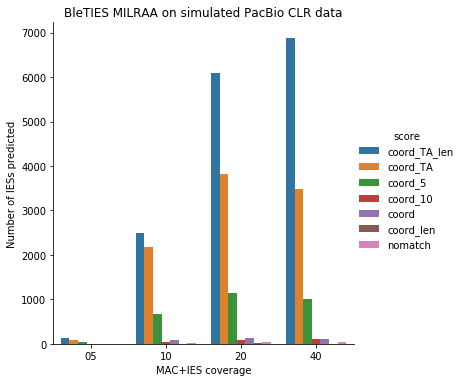

In [5]:
sns.catplot(hue='score',x='iescov',kind='count',data=out)
plt.xlabel("MAC+IES coverage")
plt.ylabel("Number of IESs predicted")
plt.title("BleTIES MILRAA on simulated PacBio CLR data")

In [6]:
# tabulate by score type and reformat table for barplot
cts = out[['iescov','score']].groupby(['iescov','score']).size().reset_index()
ctsspread = cts.pivot(index='iescov',columns='score',values=0).reset_index().fillna(0)

In [7]:
# Sanity check: total number per mixture ratio should match number of records in GFF
cts.pivot(index='iescov',columns='score',values=0).fillna(0).transpose().sum()

iescov
05      269.0
10     5512.0
20    11312.0
40    11642.0
dtype: float64

In [8]:
# Sanity check: total number per mixture ratio should match number of records in GFF
cts.pivot(index='iescov',columns='score',values=0).fillna(0).transpose()

iescov,05,10,20,40
score,,,,
coord,4.0,92.0,127.0,115.0
coord_10,4.0,49.0,96.0,98.0
coord_5,37.0,675.0,1152.0,1015.0
coord_TA,91.0,2184.0,3810.0,3492.0
coord_TA_len,133.0,2498.0,6087.0,6886.0
coord_len,0.0,4.0,10.0,6.0
nomatch,0.0,10.0,30.0,30.0


In [9]:
ctsspread

score,iescov,coord,coord_10,coord_5,coord_TA,coord_TA_len,coord_len,nomatch
0,05,4.0,4.0,37.0,91.0,133.0,0.0,0.0
1,10,92.0,49.0,675.0,2184.0,2498.0,4.0,10.0
2,20,127.0,96.0,1152.0,3810.0,6087.0,10.0,30.0
3,40,115.0,98.0,1015.0,3492.0,6886.0,6.0,30.0


In [10]:
# Save to file
ctsspread.to_csv("plots/ptet_sim_clr.mix.ies_results.tsv", sep="\t", index=False)

In [11]:
# Total number of IESs in the input
sum([len(iescoords[scaff]) for scaff in iescoords])

12199

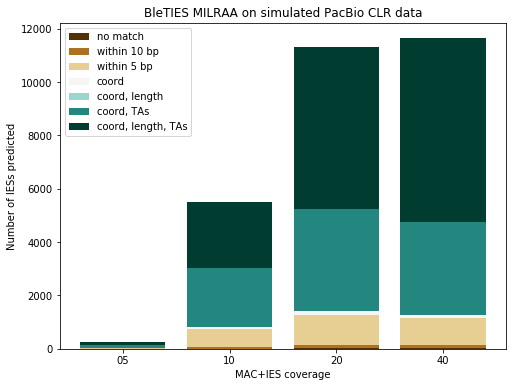

In [42]:
# Summarize key statistics in a single bargraph
pal = plt.get_cmap('BrBG', 7) # palette
plt.figure(figsize=(8,6))
plt.bar(ctsspread['iescov'], ctsspread['nomatch'], label='no match', color=pal(0))
plt.bar(ctsspread['iescov'], ctsspread['coord_10'], label='within 10 bp', color=pal(1),
        bottom = ctsspread['nomatch'])
plt.bar(ctsspread['iescov'], ctsspread['coord_5'], label='within 5 bp', color=pal(2),
        bottom = ctsspread['nomatch'] + ctsspread['coord_10'])
plt.bar(ctsspread['iescov'],ctsspread['coord'], label='coord', color=pal(3),
        bottom = ctsspread['nomatch'] + ctsspread['coord_10'] + ctsspread['coord_5'])
plt.bar(ctsspread['iescov'],ctsspread['coord_len'], label='coord, length', color=pal(4),
        bottom = ctsspread['nomatch'] + ctsspread['coord_10'] + ctsspread['coord_5'] + ctsspread['coord'])
plt.bar(ctsspread['iescov'],ctsspread['coord_TA'], label='coord, TAs', color=pal(5),
        bottom = ctsspread['nomatch'] + ctsspread['coord_10'] + ctsspread['coord_5'] + ctsspread['coord'] + ctsspread['coord_len'])
plt.bar(ctsspread['iescov'],ctsspread['coord_TA_len'], label='coord, length, TAs', color=pal(6),
        bottom = ctsspread['nomatch'] + ctsspread['coord_10'] + ctsspread['coord_5'] + ctsspread['coord'] + ctsspread['coord_len'] + ctsspread['coord_TA'])
plt.legend()
plt.xlabel("MAC+IES coverage")
plt.ylabel("Number of IESs predicted")
plt.title("BleTIES MILRAA on simulated PacBio CLR data")
plt.savefig("plots/ptet_sim_clr.mix.ies_results.png")
plt.savefig("plots/ptet_sim_clr.mix.ies_results.pdf")

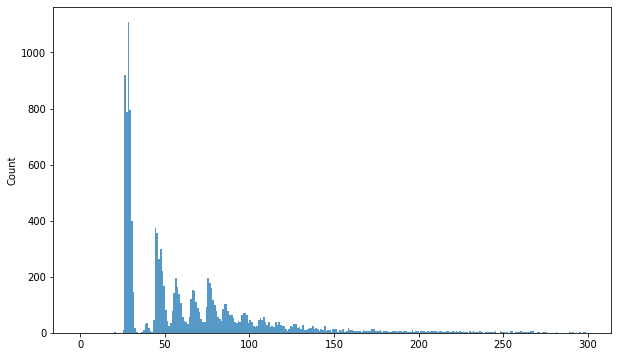

In [13]:
# Plot length histogram for original IES annotations
ieslens = []
for scaff in iescoords:
    ieslens.extend(iescoords[scaff].values())

plt.figure(figsize=(10,6))
sns.histplot([i for i in ieslens if i < 300],binwidth=1, linewidth=0)
plt.savefig("plots/ptet_ies_orig_lengths.png")
plt.savefig("plots/ptet_ies_orig_lengths.pdf")

In [14]:
out['len'] = pd.to_numeric(out['len'])

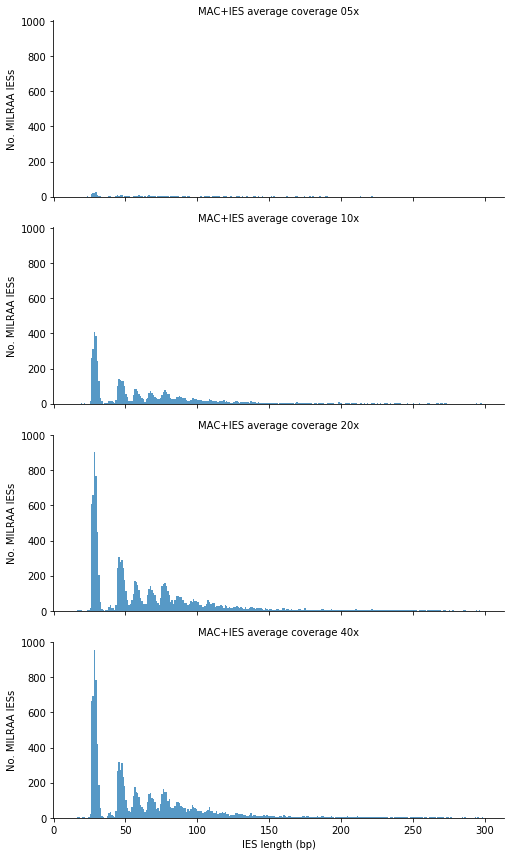

In [15]:
# Length histograms for predicted IESs at different coverage levels
grid = sns.FacetGrid(out.query('len<300'), row='iescov', height=3, aspect=7/3)
grid.map(sns.histplot, 'len', binwidth=1, linewidth=0)
grid.set_titles(row_template="MAC+IES average coverage {row_name}x")
grid.set_xlabels("IES length (bp)")
grid.set_ylabels("No. MILRAA IESs")
grid.savefig("plots/ptet_sim_clr.mix.ieslengths.png")
grid.savefig("plots/ptet_sim_clr.mix.ieslengths.pdf")

# Compare reconstructed IES seqs with original

Extract IES sequences from MAC+IES assembly

In [16]:
macies = SeqIO.to_dict(SeqIO.parse("ref/ptetraurelia_mac_51_with_ies.min100k_max100N.fa","fasta"))

In [17]:
iesrecon = {}
for cov in ['05','10','20','40']:
    iesrecon[cov] = SeqIO.to_dict(
        SeqIO.parse(
            f"bleties_pb/ptet_sim_clr.mix{cov}.milraa_subreads.milraa_ies.fasta","fasta"))
    # Adjust IES sequences to be TA bound, instead of left-most coordinate
    with open(f"bleties_pb/ptet_sim_clr.mix{cov}.milraa_subreads.milraa_ies.gff3","r") as fh:
        for line in fh:
            if not re.match(r"#", line):
                spl=line.rstrip().split("\t")
                scaff=spl[0]
                coord=spl[3]
                attr=spl[-1].rstrip(";").split(";")
                attrdict={a.split("=")[0]:a.split("=")[1] for a in attr}
                if 'ta_pointer_start' in attrdict and attrdict['ta_pointer_start'] != coord:
                    offset = int(attrdict['ta_pointer_start']) - int(coord)
                    # Adjust sequence relative to TA pointer
                    iesrecon[cov][attrdict['ID']].seq = iesrecon[cov][attrdict['ID']].seq[offset:] \
                        + iesrecon[cov][attrdict['ID']].seq[0:offset]

In [18]:
# IES annotations in published MAC+IES assembly
with open("ref/ptetraurelia_mac_51_with_ies.min100k_max100N.iescoords.json", "r") as fh:
    iescoords_orig = json.load(fh)

In [19]:
# Extract original IESs from the MAC+IES assembly
orig_ies_seqs = defaultdict(dict)
for scaff in iescoords_orig:
    scaff_mac = scaff[:-9]
    # dict of new coordinate vs. original coordinates
    new_old = dict(zip(iescoords[scaff_mac],iescoords_orig[scaff]))
    for pos in new_old:
        name = 'ies_' + scaff_mac + "_" + str(pos)
        orig_ies_seqs[scaff_mac][pos] = macies[scaff][new_old[pos][0]:new_old[pos][1]]

In [27]:
# Compare original and reconstructed IES sequences
iescomp = []
for cov in iesrecon:
    # Subset of IESs which have previously been found to have exactly matching coordinate
    # (coordinates reported differently in annotation, so were adjusted above for TA repeats)
    subset_coord_match = out.query(f"iescov=='{cov}' & score in ['coord_TA_len', 'coord_TA', 'coord', 'coord_len']")
    counter = 0
    for i, rec in subset_coord_match.iterrows():
        scaff = rec['scaffold']
        pos = rec['pos']
        seqid = rec['ID']
        if pos in orig_ies_seqs[scaff]:
            origseq = orig_ies_seqs[scaff][pos].seq[:-2]
            # Strip last two bases because in ParameciumDB both TA repeats are softmasked
            origlen = len(origseq)
            assemlen = len(iesrecon[cov][seqid].seq)
            # define percent identity as number of matching bases 
            # in whichever is longer: original seq or consensus
            alnscore = (pairwise2.align.globalxx(
                str(origseq).upper(),
                iesrecon[cov][seqid].seq,
                score_only=True))
            pid = alnscore / max([origlen, assemlen])
            mismatch = int(origlen - alnscore)
            indel = int(assemlen - origlen)
            iescomp.append([cov, seqid, pid, mismatch, indel])
iescomp_tbl = pd.DataFrame(iescomp, columns=['cov','seqid','pid','mm','indel'])

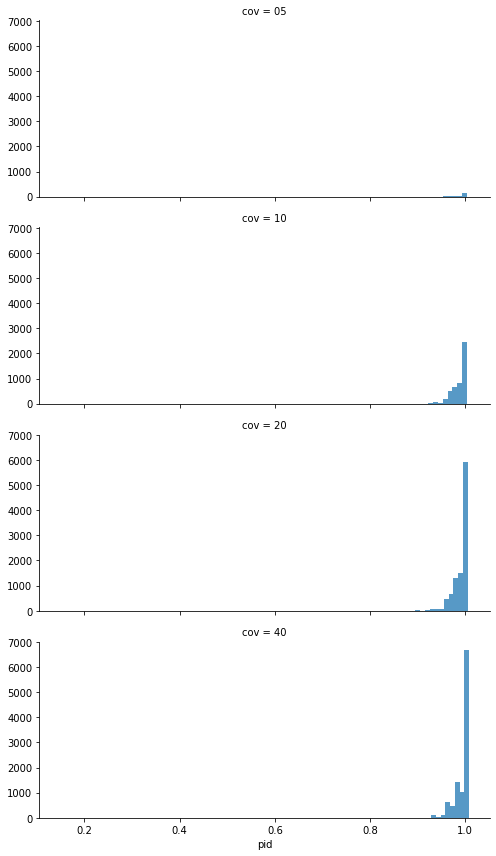

In [28]:
grid = sns.FacetGrid(iescomp_tbl, row='cov', height=3, aspect=7/3)
grid.map(sns.histplot, 'pid', binwidth=0.01, linewidth=0)
plt.savefig("plots/ptet_sim_clr.mix.ies_vs_orig_seqid.png")
plt.savefig("plots/ptet_sim_clr.mix.ies_vs_orig_seqid.png")

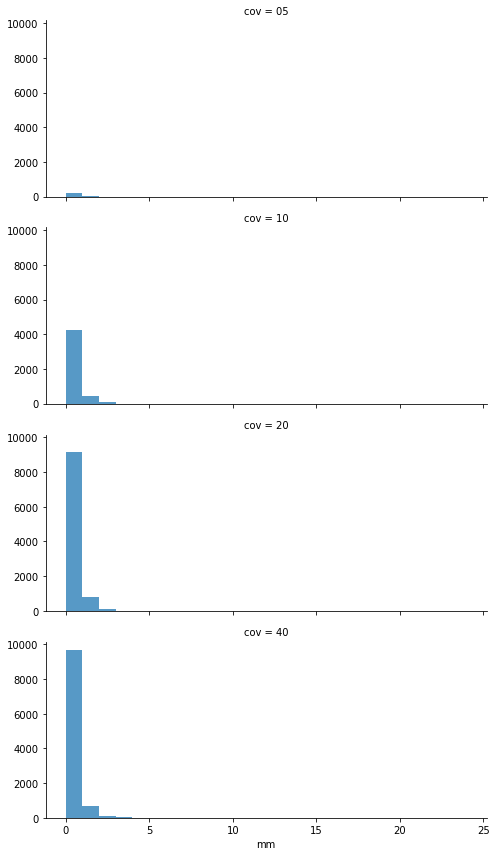

In [29]:
grid = sns.FacetGrid(iescomp_tbl.query('mm < 25'), row='cov', height=3, aspect=7/3)
grid.map(sns.histplot, 'mm', binwidth=1, linewidth=0)
plt.savefig("plots/ptet_sim_clr.mix.ies_vs_orig_mm.png")
plt.savefig("plots/ptet_sim_clr.mix.ies_vs_orig_mm.pdf")

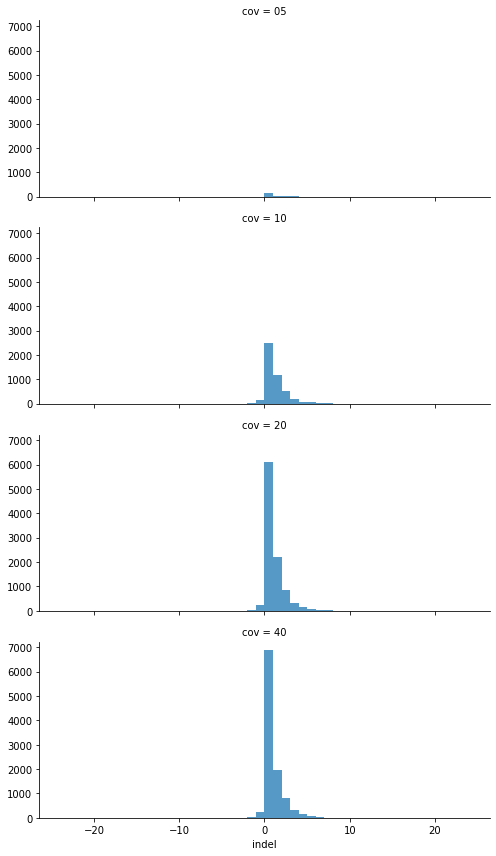

In [30]:
grid = sns.FacetGrid(iescomp_tbl.query('indel > -25 & indel < 25'), row='cov', height=3, aspect=7/3)
grid.map(sns.histplot, 'indel', binwidth=1, linewidth=0)
plt.savefig("plots/ptet_sim_clr.mix.ies_vs_orig_indel.png")
plt.savefig("plots/ptet_sim_clr.mix.ies_vs_orig_indel.pdf")

In [31]:
# Report upper percentile stats for each metric
for cov in ['05','10','20','40']:
    print(cov)
    print(iescomp_tbl.query(f"cov == '{cov}'").quantile([1, 0.99, 0.98, 0.97, 0.96, 0.95], axis=0))
    print("")

05
      pid     mm  indel
1.00  1.0  15.00   7.00
0.99  1.0   2.00   5.00
0.98  1.0   1.46   4.46
0.97  1.0   1.00   4.00
0.96  1.0   1.00   3.00
0.95  1.0   1.00   3.00

10
      pid    mm  indel
1.00  1.0  44.0   60.0
0.99  1.0   2.0    6.0
0.98  1.0   2.0    5.0
0.97  1.0   1.0    4.0
0.96  1.0   1.0    4.0
0.95  1.0   1.0    3.0

20
      pid    mm  indel
1.00  1.0  64.0   80.0
0.99  1.0   2.0    5.0
0.98  1.0   1.0    4.0
0.97  1.0   1.0    3.0
0.96  1.0   1.0    3.0
0.95  1.0   1.0    3.0

40
      pid     mm  indel
1.00  1.0  859.0   82.0
0.99  1.0    2.0    5.0
0.98  1.0    1.0    4.0
0.97  1.0    1.0    3.0
0.96  1.0    1.0    3.0
0.95  1.0    1.0    3.0



In [32]:
# Report summary statistics on sequence identity
with open("plots/ptet_sim_clr.mix.seqid_summary.tsv", "w") as fh:
    # Print header
    fh.write("\t".join(['cov','total','id 100','id 97','mm 0','mm 1','indel 0','indel 1', 'mm indel 1']))
    fh.write("\n")
    for cov in ['05','10','20','40']:
        fh.write("\t".join([
            cov,
            str(iescomp_tbl.query(f"cov == '{cov}'").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & pid == 1.0").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & pid > 0.97").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & mm == 0").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & mm <= 1").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & indel == 0").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & indel >= -1 & indel <= 1").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & indel >= -1 & indel <= 1 & mm <= 1").shape[0])
        ]))
        fh.write("\n")

In [33]:
# Pretty print
pd.read_csv("plots/ptet_sim_clr.mix.seqid_summary.tsv", sep="\t").transpose()

,0,1,2,3
cov,5,10,20,40
total,228,4778,10034,10499
id 100,126,2367,5845,6679
id 97,191,4011,8931,9545
mm 0,206,4228,9140,9681
mm 1,223,4678,9911,10357
indel 0,133,2502,6097,6892
indel 1,183,3837,8541,9099
mm indel 1,181,3791,8483,9041


# Software timing 

In [5]:
logfiles = glob.glob("bleties_pb/*.log")

In [9]:
timings = []
for logfile in logfiles:
    cov = re.search(r"mix(\d{2})", logfile).group(1)
    with open(logfile, "r") as fh:
        for line in fh:
            started = re.search(r"\[(\S+ \d{2}:\d{2}:\d{2}\,\d{3})\] .* Started BleTIES MILRAA", line)
            finished = re.search(r"\[(\S+ \d{2}:\d{2}:\d{2}\,\d{3})\] .* Finished MILRAA", line)
            if started:
                starttime = datetime.datetime.fromisoformat(started.group(1).replace(' ','T').replace(',', '.'))
            elif re.search(r"Finished", line):
                finishtime = datetime.datetime.fromisoformat(finished.group(1).replace(' ','T').replace(',', '.'))
    duration = finishtime - starttime
    timings.append({'cov' : cov, 'duration' : duration})

In [11]:
pd.DataFrame(timings)

,cov,duration
0,00,00:03:20.580000
1,05,00:03:52.976000
2,10,00:13:29.503000
3,20,00:29:51.846000
4,40,00:48:08.480000
